# Imports

In [74]:
# General includes.
import os
import random
import threading
import math
import itertools
import functools
from copy import deepcopy
#from termcolor import colored, cprint
import colored
from datetime import datetime, timedelta
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from matplotlib import pyplot as plt

# Typing includes.
from typing import Dict, List, Optional, Any

# Numerical includes.
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# pyHealth includes.
from pyhealth.datasets import BaseDataset, MIMIC3Dataset, SampleDataset , split_by_patient
from pyhealth.data import Patient, Visit, Event
from pyhealth.data import Event, Visit, Patient
from pyhealth.datasets.utils import strptime

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [75]:
# Model imports 
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, BertTokenizerFast

# Globals

In [76]:
USE_GPU_ = False
GPU_STRING_ = 'cuda'
DATA_DIR_ = '../data_input_path/mimic'
BATCH_SIZE_ = 32
EMBEDDING_DIM_ = 264  # BERT requires a multiple of 12
SHUFFLE_ = True
SAMPLE_MULTIPLIER_ = 3

# TBD
CACHE_DIR_ = 'cache'

# Set seed for reproducibility.
seed = 90210
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Preprocessing

### Load MIMIC III Data

In [77]:
from pyhealth.medcode import InnerMap, ICD9CM

icd9cm = InnerMap.load("ICD9CM")
icd9cm.lookup("428.0") # get detailed info
icd9cm.get_ancestors("428.0") # get parents

print(icd9cm.lookup("78951")) # get detailed info
print(f'78951 ancestors {icd9cm.get_ancestors("78951")}') # get parents

print(icd9cm.lookup("7895")) # get detailed info
print(f'7895 ancestors {icd9cm.get_ancestors("7895")}') # get parents


print(icd9cm.lookup("7894")) # get detailed info
print(f'7894 ancestors {icd9cm.get_ancestors("7894")}') # get parents

print(icd9cm.lookup("78941")) # get detailed info
print(f'78941 ancestors {icd9cm.get_ancestors("78941")}') # get parents

print(ICD9CM.standardize('78951'))
print(ICD9CM.standardize('7895'))

Malignant ascites
78951 ancestors ['789.5', '789', '780-789.99', '780-799.99', '001-999.99']
Ascites
7895 ancestors ['789', '780-789.99', '780-799.99', '001-999.99']
Abdominal rigidity
7894 ancestors ['789', '780-789.99', '780-799.99', '001-999.99']
Abdominal rigidity, right upper quadrant
78941 ancestors ['789.4', '789', '780-789.99', '780-799.99', '001-999.99']
789.51
789.5


In [78]:
def _compute_duration_minutes(start_datetime: str, end_datetime: str) -> float:
    '''Return duration in minutes as a float.
    '''
    # MIMIC-III uses the following format: 2146-07-22 00:00:00
    start = datetime.strptime(start_datetime, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(start_datetime,   '%Y-%m-%d %H:%M:%S')
    return float((end - start).seconds)

class MIMIC3DatasetWrapper(MIMIC3Dataset):
    ''' Add extra tables to the MIMIC III dataset.
    
      Some of the tables we need like "D_ICD_DIAGNOSES", "D_ITEMS", "D_ICD_PROCEDURES"
      are not supported out of the box. 
      
      This class defines parsing methods to extract text data from these extra tables.
      The text data is generally joined on the PATIENTID, HADMID, ITEMID to match the
      pyHealth Vists class representation.
    '''
   
    # We need to add storage for text-based lookup tables here.
    def __init__(self, *args, **kwargs):
        self._valid_text_tables = ["D_ICD_DIAGNOSES", "D_ITEMS", "D_ICD_PROCEDURES", "D_LABITEMS"]
        self._text_descriptions = {x: {} for x in self._valid_text_tables}
        self._text_luts = {x: {} for x in self._valid_text_tables}
        super().__init__(*args, **kwargs)
    
    def get_all_tables(self) -> List[str]: 
        return list(self._text_descriptions.keys())
        
    def get_text_dict(self, table_name: str) -> Dict[str, Dict[Any, Any]]:
        return self._text_descriptions.get(table_name)
    
    def set_text_lut(self, table_name: str, lut: Dict[Any, Any]) -> None:
        self._text_luts[table_name] = lut
    
    def get_text_lut(self, table_name: str) -> Dict[Any, Any]:
        return self._text_luts[table_name]
    
#     def _validate(self) -> Dict:
#         """Helper function which validates the samples.
#         Will be called in `self.__init__()`.
#         Returns:
#             input_info: Dict, a dict whose keys are the same as the keys in the
#                 samples, and values are the corresponding input information:
#                 - "type": the element type of each key attribute, one of float,
#                     int, str.
#                 - "dim": the list dimension of each key attribute, one of 0, 1, 2, 3.
#                 - "len": the length of the vector, only valid for vector-based
#                     attributes.
#         """
#         """ 1. Check if all samples are of type dict. """
#         assert all(
#             [isinstance(s, dict) for s in self.samples],
#         ), "Each sample should be a dict"
#         keys = self.samples[0].keys()

#         """ 2. Check if all samples have the same keys. """
#         assert all(
#             [set(s.keys()) == set(keys) for s in self.samples]
#         ), "All samples should have the same keys"

#         """ 3. Check if "patient_id" and "visit_id" are in the keys."""
#         assert "patient_id" in keys, "patient_id should be in the keys"
#         assert "visit_id" in keys, "visit_id should be in the keys"
#         return {}

    
    def _add_events_to_patient_dict(
        self,
        patient_dict: Dict[str, Patient],
        group_df: pd.DataFrame,
    ) -> Dict[str, Patient]:
        #TODO(botelho3) Imported from PyHealth Base dataset githubf to
        #support parse_prescription
        """Helper function which adds the events column of a df.groupby object to the patient dict.
        
        Will be called at the end of each `self.parse_[table_name]()` function.
        Args:
            patient_dict: a dict mapping patient_id to `Patient` object.
            group_df: a df.groupby object, having two columns: patient_id and events.
                - the patient_id column is the index of the patient
                - the events column is a list of <Event> objects
        Returns:
            The updated patient dict.
        """
        for _, events in group_df.items():
            for event in events:
                patient_dict = self._add_event_to_patient_dict(patient_dict, event)
        return patient_dict

    
    def parse_prescriptions(self, patients: Dict[str, Patient]) -> Dict[str, Patient]:
        """Helper function which parses PRESCRIPTIONS table.
        
        TODO(botelho3) - we have to override this to include the text fields. The
        prescriptions table does not link to a separate D_ICD_* table in MIMIC-III
        thtat contains text descriptions of the prescription. The text descriptions
        are in the columns of this table. Regular pyHealth ignores these columns. We
        override this method to appent pyHealth Event objects containing the text
        columns to each patient.
        
        Will be called in `self.parse_tables()`
        Docs:
            - PRESCRIPTIONS: https://mimic.mit.edu/docs/iii/tables/prescriptions/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The updated patients dict.
        """
        table = "PRESCRIPTIONS"
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            low_memory=False,
            dtype={"SUBJECT_ID": str, "HADM_ID": str, "NDC": str,
                   "DRUG_TYPE": str, "DRUG": str,
                   "PROD_STRENGTH": str, "ROUTE": str, "ENDDATE": str},
        )
        # drop records of the other patients
        df = df[df["SUBJECT_ID"].isin(patients.keys())]
        # drop rows with missing values
        df = df.dropna(subset=["SUBJECT_ID", "HADM_ID", "NDC", "DRUG_TYPE", "DRUG"])
        # sort by start date and end date
        df = df.sort_values(
            ["SUBJECT_ID", "HADM_ID", "STARTDATE", "ENDDATE"], ascending=True
        )
        # group by patient and visit
        group_df = df.groupby("SUBJECT_ID")
        
        # parallel unit for prescription (per patient)
        def prescription_unit(p_id, p_info):
            events = []
            for v_id, v_info in p_info.groupby("HADM_ID"):
                zipped = zip(v_info["STARTDATE"], v_info["NDC"], v_info["DRUG_TYPE"],
                             v_info["DRUG"], v_info["PROD_STRENGTH"], v_info["ROUTE"],
                             v_info["ENDDATE"])
                for timestamp, code, dtype, dname, dose, route, endtime in zipped:
                    assert(type(dname) is str)
                    event = Event(
                        code=code,
                        table=table,
                        vocabulary="NDC",
                        visit_id=v_id,
                        patient_id=p_id,
                        timestamp=strptime(timestamp),
                        dtype=dtype,
                        dname=dname,
                        dose=dose,
                        route=route,
                        duration=_compute_duration_minutes(timestamp, endtime),
                    )
                    events.append(event)
            return events

                # parallel apply
        group_df = group_df.parallel_apply(
            lambda x: prescription_unit(x.SUBJECT_ID.unique()[0], x)
        )

        # summarize the results
        # print(f'BASE {dir(BaseDataset)}')
        # print(f'MIMIC {dir(MIMIC3Dataset)}')
        # print(f'WRAPPER {dir(self)}')
        # # patients = BaseDataset._add_events_to_patient_dict(patients, group_df)
        # # patients = self._add_events_to_patient_dict(patients, group_df)
        patients = self._add_events_to_patient_dict(patients, group_df)
        return patients
    
    # Note the name has to match the table name exactly.
    # See https://github.com/sunlabuiuc/PyHealth/blob/master/pyhealth/datasets/mimic3.py#L71.
    def parse_d_icd_diagnoses(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_ICD_DIAGNOSIS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_ICD_DIAGNOSIS: https://mimic.mit.edu/docs/iii/tables/d_icd_diagnoses/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ICD_DIAGNOSES.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text diagnosis description lookup
            for DescEmb.
        """
        table = "D_ICD_DIAGNOSES"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"],
            dtype={"ICD9_CODE": str, "SHORT_TITLE": str, "LONG_TITLE": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ICD9_CODE"], ascending=True)
       
        # print(df.head())
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    def parse_d_labitems(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_LABITEMS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_LABITEMS: https://mimic.mit.edu/docs/iii/tables/d_labitems/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_LABITEMS.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text lab measurement description lookup
            for DescEmb.
        """
        table = "D_LABITEMS"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ITEMID", "LABEL", "CATEGORY", "FLUID"],
            dtype={"ITEMID": str, "LABEL": str, "CATEGORY": str, "FLUID": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ITEMID", "LABEL", "CATEGORY", "FLUID"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ITEMID"], ascending=True)
       
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    
    def parse_d_items(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        # TODO(botelho3) - Note this may not be totally useable because the ITEMID
        # uinqiue key only links to these tables using ITEMID
        #   - INPUTEVENTS_MV 
        #   - OUTPUTEVENTS on ITEMID
        #   - PROCEDUREEVENTS_MV on ITEMID
        # 
        # Not to the tables we want e.g. 
        """Helper function which parses D_ITEMS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_ITEMS: https://mimic.mit.edu/docs/iii/tables/d_items/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ITEMS.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text inputs/output/procedure events lookup
            for DescEmb.
        """
        table = "D_ITEMS"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ITEMID", "LABEL", "CATEGORY"],
            dtype={"ITEMID": str, "LABEL": str, "CATEGORY": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ITEMID", "LABEL", "CATEGORY"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ITEMID"], ascending=True)
       
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    
    def parse_d_icd_procedures(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_ICD_PROCEDURES table.
        
        Will be called in `self.parse_tables()`
        Docs:
            - D_ICD_PROCEDURES: https://mimic.mit.edu/docs/iii/tables/d_icd_procedures/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ICD_PROCEDURES.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text procedure description lookup for DescEmb.
        """
        table = "D_ICD_PROCEDURES"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"],
            dtype={"ICD9_CODE": str, "SHORT_TITLE": str, "LONG_TITLE": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ICD9_CODE"], ascending=True)
       
        # print(df.head())
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    

In [79]:
print(f'Reading data from: `{os.path.join(os.getcwd(), DATA_DIR_)}`')

mimic3base = MIMIC3DatasetWrapper(
    # root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    root=os.path.join(os.getcwd(), DATA_DIR_),
    tables=["D_ICD_DIAGNOSES", "D_ICD_PROCEDURES", "D_ITEMS", "D_LABITEMS",
            "DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], # "LABEVENTS"],
    # map all NDC codes to ATC 3-rd level codes in these tables
    # See https://en.wikipedia.org/wiki/Anatomical_Therapeutic_Chemical_Classification_System.
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    # Slow
    refresh_cache=True,
)

mimic3base.stat()
mimic3base.info()


Reading data from: `/home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/../data_input_path/mimic`


Parsing PATIENTS and ADMISSIONS: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 853.62it/s]


Parsing D_ICD_DIAGNOSES
Parsing D_ICD_PROCEDURES
Parsing D_ITEMS
Parsing D_LABITEMS


Parsing PROCEDURES_ICD: 100%|██████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 13263.46it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Mapping codes: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.97it/s]



Statistics of base dataset (dev=False):
	- Dataset: MIMIC3DatasetWrapper
	- Number of patients: 100
	- Number of visits: 129
	- Number of visits per patient: 1.2900
	- Number of events per visit in D_ICD_DIAGNOSES: 0.0000
	- Number of events per visit in D_ICD_PROCEDURES: 0.0000
	- Number of events per visit in D_ITEMS: 0.0000
	- Number of events per visit in D_LABITEMS: 0.0000
	- Number of events per visit in DIAGNOSES_ICD: 13.6512
	- Number of events per visit in PROCEDURES_ICD: 3.9225
	- Number of events per visit in PRESCRIPTIONS: 115.6667


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



In [80]:
# https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial
class BERTClassification(nn.Module):
    def __init__ (self):
        super(BERTClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.bert_drop = nn.Dropout(0.4)
        self.out = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooledOut = self.bert(ids, attention_mask = mask,
                                token_type_ids=token_type_ids)
        bertOut = self.bert_drop(pooledOut)
        output = self.out(bertOut)

        return output

In [81]:
table_names = mimic3base.get_all_tables()
print(table_names)

print('\033[92m' '====Tables====\n' '\033[0m')
# print(colored('====Tables====\n', 'green'))
# print(colored.fg('green') + '====Tables====\n')
for t in table_names:
    d = mimic3base.get_text_dict(t)
    print(f"Table: {t}")
    print(d['data'][:5])
    print('\n\n')

# Take the cached tables from the parse_tables function and build the {ICD9 -> (short_name, long_name)}
# lookup tables.
for t in table_names:
    d = mimic3base.get_text_dict(t)
    d = d['data']
    lut = {record[0]: record[1:] for record in d}
    mimic3base.set_text_lut(t,  lut)
    
print('\033[92m' '====Luts====\n' '\033[0m')
# print(f'{colored.fg("green")} ====Luts====\n')
for t in table_names:
    d = mimic3base.get_text_lut(t)
    print(f"Lut {t}:\n{dict(itertools.islice(d.items(), 2))}")

['D_ICD_DIAGNOSES', 'D_ITEMS', 'D_ICD_PROCEDURES', 'D_LABITEMS']
====Tables====

Table: D_ICD_DIAGNOSES
[['0010', 'Cholera d/t vib cholerae', 'Cholera due to vibrio cholerae'], ['0011', 'Cholera d/t vib el tor', 'Cholera due to vibrio cholerae el tor'], ['0019', 'Cholera NOS', 'Cholera, unspecified'], ['0020', 'Typhoid fever', 'Typhoid fever'], ['0021', 'Paratyphoid fever a', 'Paratyphoid fever A']]



Table: D_ITEMS
[['1126', 'Art.pH', 'ABG'], ['1127', 'WBC   (4-11,000)', 'Hematology'], ['1520', 'ACT', 'Coags'], ['1521', 'Albumin', 'Chemistry'], ['1522', 'Calcium', 'Chemistry']]



Table: D_ICD_PROCEDURES
[['0001', 'Ther ult head & neck ves', 'Therapeutic ultrasound of vessels of head and neck'], ['0002', 'Ther ultrasound of heart', 'Therapeutic ultrasound of heart'], ['0003', 'Ther ult peripheral ves', 'Therapeutic ultrasound of peripheral vascular vessels'], ['0009', 'Other therapeutic ultsnd', 'Other therapeutic ultrasound'], ['0010', 'Implant chemothera agent', 'Implantation of ch

### Tasks

Declare tasks for 2 of the 5 prediction tasks specified in the paper. We will create dataloaders for each task that contain the ICD codes and the raw text for each (patient, visit).

#### CodeEMB Pred tasks

In [82]:
# The original authors tackled 5 tasks
#   1. readmission
#   2. mortality
#   3. an ICU stay exceeding three days
#   4. an ICU stay exceeding seven days
#   5. diagnosis prediction

def readmission_pred_task(patient, time_window=3):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []

    # we will drop the last visit
    for i in range(len(patient) - 1):
        visit: Visit = patient[i]
        next_visit: Visit = patient[i + 1]

        # step 1: define the readmission label 
        # get time difference between current visit and next visit
        time_diff = (next_visit.encounter_time - visit.encounter_time).days
        readmission_label = 1 if time_diff < time_window else 0
        
        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        
        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0:
            continue
        if len(conditions) + len(procedures) + len(drugs_full) < 5:
            # Exclude stays with less than 5 procedures.
            continue
        
        # step 3.5: build text lists from the ICD codes
        diag_lut = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        proc_lut = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        conditions_text = [diag_lut.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [proc_lut.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
            
        # step 4: assemble the samples
        # TODO: should also exclude visit with age < 18
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": readmission_label,
            }
        )
    # no cohort selection
    return samples


def mortality_pred_task(patient):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []

    # loop over all visits but the last one
    for i in range(len(patient) - 1):

        # visit and next_visit are both <pyhealth.data.Visit> objects
        # there are no vists.attr_dict keys
        visit = patient[i]
        next_visit = patient[i + 1]
        # if i == 0: print(visit)

        # step 1: define the mortality_label
        if next_visit.discharge_status not in [0, 1]:
            mortality_label = 0
        else:
            mortality_label = int(next_visit.discharge_status)

        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        # if i == 0: print([d.attr_dict for d in drugs_full])
        # if i == 0: print(conditions)
        # if i == 0: print(procedures)
        # if i == 0: print(drugs)
        # TODO(botelho3) - add this datasource back in once we have full MIMIC-III dataset.
        # labevents = visit.get_code_list(table="LABEVENTS")

        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0:
            continue
        if len(conditions) + len(procedures) + len(drugs_full) < 5:
            # Exclude stays with less than 5 procedures.
            continue
        
        # step 3.5: build text lists from the ICD codes
        diag_lut = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        proc_lut = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        # if i == 0: print(diag_lut)
        # if i == 0: print(proc_lut)
        # Index 0 is shortname, index 1 is longname.
        # print([str(cond) + ' ' + str(diag_lut.get(cond)) for cond in conditions])
        # print(proc_lut.get(procedures[0]))
        conditions_text = [diag_lut.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [proc_lut.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
        # TODO(botelho3) - add the labevents data source back in once we have full MIMIC-III dataset.
        # labevents_text =
        
        # step 4: assemble the samples
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": mortality_label,
            }
        )
    return samples

def mortality_pred_task_v2(MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_, patient):
    """
    patient is a <pyhealth.data.Patient> object
    each sample is a list of vists for 1 patient.
    """
   
    # TODO(botelho3) - stupid hack around the limitations of SampleDataset validator.
    kMaxVisits = 5
    
    if len(patient) < 1:
        return []
    
    if len(patient) > kMaxVisits:
        return []
        
    samples = [{
        "visit_id": patient[0].visit_id,
        "patient_id": patient.patient_id,
        # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
        "num_visits": 0,
        "conditions": [[] for v in range(kMaxVisits)],
        "procedures": [[] for v in range(kMaxVisits)],
        "conditions_text": [[] for v in range(kMaxVisits)],
        "procedures_text": [[] for v in range(kMaxVisits)],
        "drugs": [[] for v in range(kMaxVisits)],
        "drugs_text": [[] for v in range(kMaxVisits)],
        # "labevents": labevents,
        # "labevents_text": labevents_text
        "label": 0,
    }]
    
    global_mortality_label = 0
    # loop over all visits but the last one
    for i in range(len(patient)):

        # visit and next_visit are both <pyhealth.data.Visit> objects
        # there are no vists.attr_dict keys
        visit: Visit = patient[i]
        # next_visit: Visit = patient[i + 1]
        # if i == 0: print(visit)

        # step 1: define the mortality_label
        # if next_visit.discharge_status not in [0, 1]:
        #     mortality_label = 0
        # else:
        #     mortality_label = int(next_visit.discharge_status)
        mortality_label = int(visit.discharge_status)
        global_mortality_label |= mortality_label

    # loop over all visits but the last one
    for i in range(len(patient)):

        # visit and next_visit are both <pyhealth.data.Visit> objects
        # there are no vists.attr_dict keys
        visit = patient[i]

        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        # if i == 0: print([d.attr_dict for d in drugs_full])
        # if i == 0: print(conditions)
        # if i == 0: print(procedures)
        # if i == 0: print(drugs)
        # TODO(botelho3) - add this datasource back in once we have full MIMIC-III dataset.
        # labevents = visit.get_code_list(table="LABEVENTS")

        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) * len(drugs_full) == 0:
            continue
        if len(conditions) + len(procedures) + len(drugs_full) < 5:
            # Exclude stays with less than 5 procedures.
            continue
        
        # step 3.5: build text lists from the ICD codes
        diag_lut = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        proc_lut = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        # if i == 0: print(diag_lut)
        # if i == 0: print(proc_lut)
        # Index 0 is shortname, index 1 is longname.
        # print([str(cond) + ' ' + str(diag_lut.get(cond)) for cond in conditions])
        # print(proc_lut.get(procedures[0]))
        conditions_text = [diag_lut.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [proc_lut.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
        # TODO(botelho3) - add the labevents data source back in once we have full MIMIC-III dataset.
        # labevents_text =
        
        # step 4: assemble the samples
        # Each field is a list of visits.
        samples[0]['num_visits'] = samples[0]['num_visits'] + 1
        samples[0]['conditions'][i]=conditions
        samples[0]['procedures'][i]=procedures
        samples[0]['conditions_text'][i]= conditions_text
        samples[0]['procedures_text'][i] = procedures_text
        samples[0]['drugs'][i] = drugs
        samples[0]['drugs_text'][i] = drugs_text
    samples[0]['label'] = global_mortality_label
    
    for visit in samples[0]['conditions']:
        for code in visit:
            MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_[code] = MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_.get(code, 0) + 1

    samples.extend(
        list(deepcopy(samples[0]) for s in range(SAMPLE_MULTIPLIER_-1))
    )
        
    return samples


#### DescEmb Pred Tasks

In [83]:
# The original authors tackled 5 tasks
#   1. readmission
#   2. mortality
#   3. an ICU stay exceeding three days
#   4. an ICU stay exceeding seven days
#   5. diagnosis prediction

READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_ = {}
READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ = {}
#{code: idx for idx, code in enumerate(READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_.keys())}
def readmission_pred_task_per_patient(patient, time_window=3):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []
    visits = []
    kMaxListSize = 40
   
    # Length 1 patients by defn are not readmitted.
    if len(patient) < 1:
        return samples

    # we will drop the last visit
    global_readmission_label = 0
    for i in range(len(patient) - 1):
        visit: Visit = patient[i]
        next_visit: Visit = patient[i + 1]

        # step 1: define the readmission label 
        # get time difference between current visit and next visit
        time_diff = (next_visit.encounter_time - visit.encounter_time).days
        readmission_label = 1 if time_diff < time_window else 0
        global_readmission_label |= readmission_label  
       
    for i in range(len(patient)):
        visit: Visit = patient[i]
        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        # drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs = [x.code for x in visit.get_event_list(table="PRESCRIPTIONS")]
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        
        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0:
            continue
        if len(conditions) + len(procedures) + len(drugs_full) < 5:
            # Exclude stays with less than 5 procedures.
            continue
        
        # step 3.5: build text lists from the ICD codes
        d_diag = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        d_proc = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        conditions_text = [d_diag.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [d_proc.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
            
        # step 4: assemble the samples
        visits.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": global_readmission_label,
            }
        )
        

    # Return empty list, didn't meet exclusion criteria.
    num_visits = len(visits)
    if num_visits < 1:
        return samples
    
    def pad_field(field, visits, empty_val: Any):
        l = [empty_val for x in range(kMaxListSize)]
        data = [x[field] for x in visits]
        data = list(itertools.chain.from_iterable(data))
        slice_size = min(kMaxListSize, len(data)) - 1
        l[:slice_size] = data[:slice_size]
        return l, slice_size 
    
    conditions, conditions_pad = pad_field("conditions", visits, '0')
    conditions_text, conditions_text_pad = pad_field("conditions_text", visits, '')
    procedures, procedures_pad = pad_field("procedures", visits, '0')
    procedures_text, procedures_text_pad = pad_field("procedures_text", visits, '')
    drugs, drugs_pad = pad_field("drugs", visits, '0')
    drugs_text, drugs_text_pad = pad_field("drugs_text", visits, '')
    assert(drugs_pad == drugs_text_pad)
    sample = {
        "patient_id": patient.patient_id,
        # TODO(botelho3) Why does pyhealth require a visit id in the keys if we're combining vists?
        "visit_id": visits[0]["visit_id"],
        "num_visits": num_visits,
        # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
        "conditions": conditions,
        "conditions_text": conditions_text,
        "procedures": procedures,
        "procedures_text": procedures_text,
        "drugs": drugs,
        "drugs_text": drugs_text,
        
        "conditions_pad": conditions_pad,
        "procedures_pad": procedures_pad,
        "conditions_text_pad": conditions_text_pad,
        "procedures_text_pad": procedures_text_pad,
        "drugs_pad": drugs_pad,
        "drugs_text_pad": drugs_text_pad,
        # "labevents": labevents,
        # "labevents_text": labevents_text
        "label": global_readmission_label,
    }
    # sample = {
    #     "patient_id": patient.patient_id,
    #     # TODO(botelho3) Why does pyhealth require a visit id in the keys if we're combining vists?
    #     "visit_id": visits[0]["visit_id"],
    #     "num_visits": num_visits,
    #     # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
    #     "conditions": [[x["conditions"] for x in visits]],
    #     "procedures": [[x["procedures"] for x in visits]],
    #     "conditions_text": [[x["conditions_text"] for x in visits]],
    #     "procedures_text": [[x["procedures_text"] for x in visits]],
    #     "drugs": [[[x["drugs"] for x in visits]]],
    #     "drugs_text": [[x["drugs_text"] for x in visits]],
    #     # "labevents": labevents,
    #     # "labevents_text": labevents_text
    #     "label": global_readmission_label,
    # }
    for code in sample['conditions']:
        READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_[code] = READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_.get(code, 0) + 1

    samples.extend(
        list(deepcopy(sample) for s in range(SAMPLE_MULTIPLIER_))
    )
    return samples


MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_ = {}
MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {}
#{code: idx for idx, code in enumerate(MORTALITY_PER_PATIENT_ICD_9_CODES_.keys())}
def mortality_pred_task_per_patient(patient):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []
    visits = []
    kMaxListSize = 40

    global_mortality_label = 0
    # loop over all visits but the last one
    for i in range(len(patient)):

        # visit and next_visit are both <pyhealth.data.Visit> objects
        # there are no vists.attr_dict keys
        visit: Visit = patient[i]
        # next_visit: Visit = patient[i + 1]
        # if i == 0: print(visit)

        # step 1: define the mortality_label
        # if next_visit.discharge_status not in [0, 1]:
        #     mortality_label = 0
        # else:
        #     mortality_label = int(next_visit.discharge_status)
        mortality_label = int(visit.discharge_status)
        global_mortality_label |= mortality_label
        
    # loop over all visits but the last one
    for i in range(len(patient)):
        visit: Visit = patient[i]
        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        # drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs = [x.code for x in visit.get_event_list(table="PRESCRIPTIONS")]
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        # if i == 0: print([d.attr_dict for d in drugs_full])
        # if i == 0: print(conditions)
        # if i == 0: print(procedures)
        # if i == 0: print(drugs)
        # TODO(botelho3) - add this datasource back in once we have full MIMIC-III dataset.
        # labevents = visit.get_code_list(table="LABEVENTS")

        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0:
            continue
        if len(conditions) + len(procedures) + len(drugs_full) < 5:
            # Exclude stays with less than 5 procedures.
            continue
        
        # step 3.5: build text lists from the ICD codes
        diag_lut = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        proc_lut = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        # if i == 0: print(d_diag)
        # if i == 0: print(d_proc)
        # Index 0 is shortname, index 1 is longname.
        # print([str(cond) + ' ' + str(d_diag.get(cond)) for cond in conditions])
        # print(d_proc.get(procedures[0]))
        conditions_text = [diag_lut.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [proc_lut.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
        # TODO(botelho3) - add the labevents data source back in once we have full MIMIC-III dataset.
        # labevents_text =
        
        # step 4: assemble the samples into a pyHealth Visit.
        visits.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": global_mortality_label,
            }
        )
    
    # Return empty list, didn't meet exclusion criteria.
    num_visits = len(visits)
    if num_visits < 1:
        return samples
    
    def pad_field(field, visits, empty_val: Any):
        l = [empty_val for x in range(kMaxListSize)]
        data = [x[field] for x in visits]
        data = list(itertools.chain.from_iterable(data))
        slice_size = min(kMaxListSize, len(data))
        l[:slice_size] = data[:slice_size]
        return l, slice_size
    
    conditions, conditions_pad = pad_field("conditions", visits, '0')
    conditions_text, conditions_text_pad = pad_field("conditions_text", visits, '')
    procedures, procedures_pad = pad_field("procedures", visits, '0')
    procedures_text, procedures_text_pad = pad_field("procedures_text", visits, '')
    drugs, drugs_pad = pad_field("drugs", visits, '0')
    drugs_text, drugs_text_pad = pad_field("drugs_text", visits, '')
    assert(drugs_pad == drugs_text_pad)
    sample = {
        "patient_id": patient.patient_id,
        # TODO(botelho3) Why does pyhealth require a visit id in the keys if we're combining vists?
        "visit_id": visits[0]["visit_id"],
        "num_visits": num_visits,
        # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
        "conditions": conditions,
        "conditions_text": conditions_text,
        "procedures": procedures,
        "procedures_text": procedures_text,
        "drugs": drugs,
        "drugs_text": drugs_text,
        
        "conditions_pad": conditions_pad,
        "procedures_pad": procedures_pad,
        "conditions_text_pad": conditions_text_pad,
        "procedures_text_pad": procedures_text_pad,
        "drugs_pad": drugs_pad,
        "drugs_text_pad": drugs_text_pad,
        # "labevents": labevents,
        # "labevents_text": labevents_text
        "label": global_mortality_label,
    }
    # sample = {
    #     "patient_id": patient.patient_id,
    #     # TODO(botelho3) Why does pyhealth require a visit id in the keys if we're combining vists?
    #     "visit_id": visits[0]["visit_id"],
    #     "num_visits": num_visits,
    #     # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
    #     "conditions": [[x["conditions"] for x in visits]],
    #     "procedures": [[x["procedures"] for x in visits]],
    #     "conditions_text": [[x["conditions_text"] for x in visits]],
    #     "procedures_text": [[x["procedures_text"] for x in visits]],
    #     "drugs": [[[x["drugs"] for x in visits]]],
    #     "drugs_text": [[x["drugs_text"] for x in visits]],
    #     # "labevents": labevents,
    #     # "labevents_text": labevents_text
    #     "label": global_mortality_label,
    # }
    
    for code in sample['conditions']:
        MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_[code] = MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_.get(code, 0) + 1

    samples.extend(
        list(deepcopy(sample) for s in range(SAMPLE_MULTIPLIER_))
    )
    return samples

#### Test Load Readmission Dataset

In [84]:
# set_task() returns a SampleEHRDataset object
readm_dataset = mimic3base.set_task(readmission_pred_task_per_patient)
READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ = {
    code: idx for idx, code in enumerate(sorted(READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_.keys()))
}
readm_dataset.stat()
readm_dataset.samples[1]
# TODO(botelho3) could try a freq codes limit on this.
print(f"READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: {len(READMISSION_PER_PATIENT_ICD_9_CODE2IDX_)}\n"
      f"{READMISSION_PER_PATIENT_ICD_9_CODE2IDX_}")

Generating samples for readmission_pred_task_per_patient: 100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 1941.38it/s]

Statistics of sample dataset:
	- Dataset: MIMIC3DatasetWrapper
	- Task: readmission_pred_task_per_patient
	- Number of samples: 261
	- Number of patients: 87
	- Number of visits: 87
	- Number of visits per patient: 3.0000
	- num_visits:
		- Number of num_visits per sample: 1.0000
		- Number of unique num_visits: 4
		- Distribution of num_visits (Top-10): [(1, 228), (2, 24), (3, 6), (14, 3)]
	- conditions:
		- Number of conditions per sample: 40.0000
		- Number of unique conditions: 482
		- Distribution of conditions (Top-10): [('0', 6726), ('4019', 102), ('42731', 99), ('4280', 99), ('5849', 99), ('51881', 78), ('25000', 69), ('486', 69), ('99592', 51), ('0389', 48)]
	- conditions_text:
		- Number of conditions_text per sample: 40.0000
		- Number of unique conditions_text: 464
		- Distribution of conditions_text (Top-10): [('', 6843), ('Unspecified essential hypertension', 102), ('Atrial fibrillation', 99), ('Congestive heart failure, unspecified', 99), ('Acute kidney failure, unspecif

#### Test Load Mortality Dataset

In [85]:
mor_dataset = mimic3base.set_task(mortality_pred_task_per_patient)
MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {
    code: idx for idx, code in enumerate(sorted(MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_.keys()))
}
mor_dataset.stat()
mor_dataset.samples[1]
# TODO(botelho3) could try a freq codes limit on this.
print(f"MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: {len(MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_)}\n"
      f"{MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_}")

Generating samples for mortality_pred_task_per_patient: 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 1761.68it/s]


Statistics of sample dataset:
	- Dataset: MIMIC3DatasetWrapper
	- Task: mortality_pred_task_per_patient
	- Number of samples: 261
	- Number of patients: 87
	- Number of visits: 87
	- Number of visits per patient: 3.0000
	- num_visits:
		- Number of num_visits per sample: 1.0000
		- Number of unique num_visits: 4
		- Distribution of num_visits (Top-10): [(1, 228), (2, 24), (3, 6), (14, 3)]
	- conditions:
		- Number of conditions per sample: 40.0000
		- Number of unique conditions: 506
		- Distribution of conditions (Top-10): [('0', 6465), ('4019', 114), ('42731', 102), ('5849', 102), ('4280', 99), ('25000', 78), ('51881', 78), ('486', 69), ('2724', 57), ('99592', 54)]
	- conditions_text:
		- Number of conditions_text per sample: 40.0000
		- Number of unique conditions_text: 486
		- Distribution of conditions_text (Top-10): [('', 6591), ('Unspecified essential hypertension', 114), ('Atrial fibrillation', 102), ('Acute kidney failure, unspecified', 102), ('Congestive heart failure, unspec

In [86]:
# The original authors tackled 5 tasks
#   1. readmission
#   2. mortality
#   3. an ICU stay exceeding three days
#   4. an ICU stay exceeding seven days
#   5. diagnosis prediction

def readmission_pred_no_visit_task(patient, time_window=3):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []

    # we will drop the last visit
    for i in range(len(patient) - 1):
        visit: Visit = patient[i]
        next_visit: Visit = patient[i + 1]

        # step 1: define the readmission label 
        # get time difference between current visit and next visit
        time_diff = (next_visit.encounter_time - visit.encounter_time).days
        readmission_label = 1 if time_diff < time_window else 0
        
        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        
        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0:
            continue
        
        # step 3.5: build text lists from the ICD codes
        d_diag = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        d_proc = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        conditions_text = [d_diag.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [d_proc.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
            
        # step 4: assemble the samples
        # TODO: should also exclude visit with age < 18
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": readmission_label,
            }
        )
    # no cohort selection
    return samples


def mortality_pred_no_visit_task(patient):
    """
    patient is a <pyhealth.data.Patient> object
    """
    samples = []

    # loop over all visits but the last one
    for i in range(len(patient) - 1):

        # visit and next_visit are both <pyhealth.data.Visit> objects
        # there are no vists.attr_dict keys
        visit = patient[i]
        next_visit = patient[i + 1]
        # if i == 0: print(visit)

        # step 1: define the mortality_label
        if next_visit.discharge_status not in [0, 1]:
            mortality_label = 0
        else:
            mortality_label = int(next_visit.discharge_status)

        # step 2: get code-based feature information
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        drugs_full = visit.get_event_list(table="PRESCRIPTIONS")
        # if i == 0: print([d.attr_dict for d in drugs_full])
        # if i == 0: print(conditions)
        # if i == 0: print(procedures)
        # if i == 0: print(drugs)
        # TODO(botelho3) - add this datasource back in once we have full MIMIC-III dataset.
        # labevents = visit.get_code_list(table="LABEVENTS")

        # step 3: exclusion criteria: visits without condition, procedure, or drug
        if len(conditions) * len(procedures) == 0 * len(drugs_full) == 0: continue
        
        # step 3.5: build text lists from the ICD codes
        d_diag = mimic3base.get_text_lut("D_ICD_DIAGNOSES")
        d_proc = mimic3base.get_text_lut("D_ICD_PROCEDURES")
        # if i == 0: print(d_diag)
        # if i == 0: print(d_proc)
        # Index 0 is shortname, index 1 is longname.
        # print([str(cond) + ' ' + str(d_diag.get(cond)) for cond in conditions])
        # print(d_proc.get(procedures[0]))
        conditions_text = [d_diag.get(cond,("", ""))[1] for cond in conditions]
        procedures_text = [d_proc.get(proc,("", ""))[1] for proc in procedures]
        drugs_text = [' '.join([d['dname'], d['dtype'], d['dose'], d['route'], str(d['duration'])])
                      for d in [d.attr_dict for d in drugs_full]]
        # TODO(botelho3) - add the labevents data source back in once we have full MIMIC-III dataset.
        # labevents_text =
        
        # step 4: assemble the samples
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                # the following keys can be the "feature_keys" or "label_key" for initializing downstream ML model
                "conditions": conditions,
                "procedures": procedures,
                "conditions_text": conditions_text,
                "procedures_text": procedures_text,
                "drugs": drugs,
                "drugs_text": drugs_text,
                # "labevents": labevents,
                # "labevents_text": labevents_text
                "label": mortality_label,
            }
        )
    return samples


# mimic3sample = mimic3base.set_task(task_fn=drug_recommendation_mimic3_fn) # use default task
# train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.8, 0.1, 0.1])

### DataLoaders and Collate

In [87]:
# def per_visit_collate_fn(data):
#     """
#     Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
#         sequences to the sample shape (max # visits, len(freq_codes)). The padding infomation
#         is stored in `mask`.
    
#     Arguments:
#         data: a list of samples fetched from `CustomDataset`
        
#     Outputs:
#         x: a tensor of shape (# patiens, max # visits, len(freq_codes)) of type torch.float
#         masks: a tensor of shape (# patiens, max # visits) of type torch.bool
#         y: a tensor of shape (# patiens) of type torch.float
        
#     Note that you can obtains the list of diagnosis codes and the list of hf labels
#         using: `sequences, labels = zip(*data)`
#     """

#     sequences, labels = zip(*data)

#     y = torch.tensor(labels, dtype=torch.float)
    
#     num_patients = len(sequences)
#     num_visits = [len(patient) for patient in sequences]
#     max_num_visits = max(num_visits)
    
#     x = torch.zeros((num_patients, max_num_visits, len(freq_codes)), dtype=torch.float)    
#     for i_patient, patient in enumerate(sequences):
#         kMaxVisits = len(patient)
#         for j_visit, visit in enumerate(patient):
#             l = len(visit)
#             for code in visit:
#                 """
#                 TODO: 1. check if code is in freq_codes;
#                       2. obtain the code index using code2idx;
#                       3. set the correspoindg element in x to 1.
#                 """
#                 try:
#                     idx = code2idx[code]
#                     x[i_patient, j_visit, idx] = 1
#                 except KeyError as e:
#                     pass
    
#     masks = torch.sum(x, dim=-1) > 0
    
#     return x, masks, y

# def collate_fn(data):
#     """
#     TODO: Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
#         sequences to the sample shape (max # visits, max # diagnosis codes). The padding infomation
#         is stored in `mask`.
    
#     Arguments:
#         data: a list of samples fetched from `CustomDataset`
        
#     Outputs:
#         x: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.long
#         masks: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.bool
#         rev_x: same as x but in reversed time. This will be used in our RNN model for masking 
#         rev_masks: same as mask but in reversed time. This will be used in our RNN model for masking
#         y: a tensor of shape (# patiens) of type torch.float
        
#     Note that you can obtains the list of diagnosis codes and the list of hf labels
#         using: `sequences, labels = zip(*data)`
#     """

#     sequences, labels = zip(*data)

#     y = torch.tensor(labels, dtype=torch.float)
    
#     num_patients = len(sequences)
#     num_visits = [len(patient) for patient in sequences]
#     num_codes = [len(visit) for patient in sequences for visit in patient]

#     max_num_visits = max(num_visits)
#     max_num_codes = max(num_codes)
    
#     x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
#     rev_x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
#     masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
#     rev_masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
#     for i_patient, patient in enumerate(sequences):
#         kMaxVisits = len(patient)
#         for j_visit, visit in enumerate(patient):
#             """
#             TODO: update `x`, `rev_x`, `masks`, and `rev_masks`
#             """
#             l = len(visit)
#             x[i_patient, j_visit, 0:l] = torch.LongTensor(visit)
#             rev_x[i_patient, kMaxVisits-1-j_visit, 0:l] = torch.LongTensor(visit)
#             masks[i_patient, j_visit, 0:l] = 1
#             rev_masks[i_patient, kMaxVisits-1-j_visit, 0:l] = 1
#         # print(f"------ v: {kMaxVisits} ------")
#         # print(x[i_patient, :, ])
#         # print(rev_x[i_patient, :, ])
#         # print(masks[i_patient, :, ])
#         # print(rev_masks[i_patient, :, ])
    
#     return x, masks, rev_x, rev_masks, y


def bert_per_patient_collate_function(data):
    """
    Collates a tensor of (batch_size, seq_len, bert_emb_len) i.e. (32, <variable_per_patient>, 768)
    Need to pad the second dimension to max(<variable_per_patient>)
    
    TODO: Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
        sequences to the sample shape (max # visits, max # diagnosis codes). The padding infomation
        is stored in `mask`.
    
    Arguments:
        data: a list of samples fetched from `CustomDataset`
        
    Outputs:
        x: a tensor of shape (batch_size, max #conditions, max embedding size) of type torch.float
        masks: a tensor of shape (batch_size, max #conditions, max embedding_size) of type torch.bool
        rev_x: same as x but in reversed time. This will be used in our RNN model for masking 
        rev_masks: same as mask but in reversed time. This will be used in our RNN model for masking
        y: a tensor of shape (batch_size) of type torch.float
        
    Note that you can obtains the list of diagnosis codes and the list of hf labels
        using: `sequences, labels = zip(*data)`
    """
    print(f"bert_per_patient_collate_function data[0] {data[0]}")
    sequences, labels = zip(*data)
    
    # Convert output labels for each sample in batch to tensor.
    # shape: (batch_size, 1)
    y = torch.tensor(labels, dtype=torch.float)
   
    num_patients = len(sequences)
    num_events = [patient.shape[0] for patient in sequences]
    embedding_length = [patient.shape[1] for patient in sequences]

    max_num_events = max(num_events)
    max_embedding_length = max(embedding_length)
    
    x = torch.zeros((num_patients, max_num_events, max_embedding_length), dtype=torch.float)
    rev_x = torch.zeros((num_patients, max_num_events, max_embedding_length), dtype=torch.float)
    masks = torch.zeros((num_patients, max_num_events, max_embedding_length), dtype=torch.bool)
    rev_masks = torch.zeros((num_patients, max_num_events, max_embedding_length), dtype=torch.bool)
    for i_patient, patient in enumerate(sequences):
        j_visits = patient.shape[0]
        # for j_visit, visit in enumerate(patient):
        """
        TODO: update `x`, `rev_x`, `masks`, and `rev_masks`
        """
        # l = len(visit)
        x[i_patient, :j_visits, :] = patient[:, :].unsqueeze(0)
        # The tensor is (seq_length, emb_size). Leave embeddings,
        # flip temporal order of code/event sequence.
        rev_x[i_patient, :j_visits, :] = torch.flip(patient, dims=[0]).unsqueeze(0)
        masks[i_patient, :j_visits, :] = 1
        rev_masks[i_patient, :j_visits, :] = 1
      
        # TODO(botelho3) - comment this out to reduce spew.
        if i_patient == 0:
            print(f"------ p: {i_patient} ------")
            print(x[i_patient, :, :25])
            print(rev_x[i_patient, :, :25])
            print(masks[i_patient, :, :25])
            print(rev_masks[i_patient, :, :25])
    
    return x, masks, rev_x, rev_masks, y



#### Bert Loader

In [88]:
class BertTextEmbedTransform(object):
    """Transform a sample's (a single visit's) text into 1 embedding vector.
    
    The embeddings of each text field are combined by embedding
    each separately then summing.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    # https://stackoverflow.com/questions/69517460/bert-get-sentence-embedding
    # https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.tokenization_utils_base.PreTrainedTokenizerBase
    # https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/

    def __init__(self, bert_model: Any, embedding_size: int, use_tokenizer_fast: bool):
        assert isinstance(embedding_size, (int, tuple))
        self.cache_dir = os.path.join(os.getcwd(), CACHE_DIR_)
        self.bert_config = BertConfig(hidden_size=EMBEDDING_DIM_)
        # self.bert_model = BertModel(self.bert_config).from_pretrained('bert-base-uncased', config=self.bert_config)
        self.bert_model = BertModel(self.bert_config).from_pretrained('bert-base-uncased')
        self.bert_config = self.bert_model.config
        self.bert_model.eval()
        if use_tokenizer_fast:
            self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', model_max_length=100)
        else:
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', model_max_length=100)
    
    def _tokenize_text(self, text: str) -> str:
        tokenized_text = self.tokenizer.tokenize(text)
        return tokenized_text
    
    def _get_embeddings_of_sentences_with_mask(self, field, pad) -> torch.tensor:
        return self._get_embeddings_of_sentences(field[:pad])
        
    
    def _get_embeddings_of_sentences(self, sentences: List[str]) -> torch.tensor:
        # tokenized_sentences = [self.tokenizer.tokenize(t, padding=True) for t in sentences]
        # print(batch_enc)
        batch_enc = self.tokenizer.batch_encode_plus(
                                sentences, padding=True,
                                return_attention_mask=True, return_length=True)
        # Convert inputs to PyTorch tensors
        # tokens_tensor = torch.tensor([tokenized_sentences])
        # segments_tensors = torch.tensor([segments_ids])
        # Convert inputs to PyTorch tensors
        batch_enc_tensor = {key:torch.LongTensor(value) for key, value in batch_enc.items()}
       
        with torch.no_grad():
            embeddings = self.bert_model(input_ids=batch_enc_tensor['input_ids'],
                                            attention_mask=batch_enc_tensor['attention_mask'])
            # embeddings, _ = self.bert_model(**batch_enc)
        # print(f'embeddings:\n {dir(embeddings)}')
        #attention = encoded['attention_mask'].reshape((lhs.size()[0], lhs.size()[1], -1)).expand(-1, -1, 768)
        return embeddings.last_hidden_state, embeddings.attentions 
    
    def __call__(self, sample):
        condition_embeddings = [None] * len(sample['conditions_text'])
        procedure_embeddings = [None] * len(sample['procedures_text'])
        drug_embeddings = [None] * len(sample['drugs_text'])
       
        if sample.get('conditions_text_pad'):
            condition_embeddings, condition_attentions = self._get_embeddings_of_sentences_with_mask(
                sample['conditions_text'], sample['conditions_text_pad'])
        else:
            condition_embeddings, condition_attentions = self._get_embeddings_of_sentences(sample['conditions_text'])
        # for cond in sample['conditions_text']:
        #     #bert_model(cond)
        #     condition_embeddings.append(cond)
        #     pass
        if sample.get('procedures_text_pad'):
            procedure_embeddings, procedure_attentions = self._get_embeddings_of_sentences_with_mask(
                sample['procedures_text'], sample['procedures_text_pad'])
        else:
            procedure_embeddings, procedure_attentions = self._get_embeddings_of_sentences(sample['procedures_text'])
        # for proc in sample['procedures_text']:
        #     #bert_model(proc)
        #     procedure_embeddings.append(proc)
        #     pass
        if (sample.get('drugs_text_pad')):
            drug_embeddings, drug_attentions = self._get_embeddings_of_sentences_with_mask(
                sample['drugs_text'], sample['drugs_text_pad'])
        else:
            drug_embeddings, drug_attentions = self._get_embeddings_of_sentences(sample['drugs_text'])
        # for drug in sample['drugs_text']:
        #     #bert_model(drug)
        #     procedure_embeddings.append(drug)
        #     pass
        
        # Take only the last hidden state embeddings from BERT.
        condition_embeddings = torch.squeeze(condition_embeddings[:, -1, :], dim=1)
        procedure_embeddings = torch.squeeze(procedure_embeddings[:, -1, :], dim=1)
        drug_embeddings = torch.squeeze(drug_embeddings[:, -1, :], dim=1)
        print(f'ce: {condition_embeddings.shape} '
              f'pe: {procedure_embeddings.shape} '
              f'de: {drug_embeddings.shape} ')
       
        stacked = torch.cat([condition_embeddings, procedure_embeddings, drug_embeddings], dim=0)
        
        # We don't want to normalize here because we need a sequence of embeddings for each sample. 
        # normalize the final row (across columns)
        # summed_embeddings = torch.sum(stacked, dim=0, keepdim=True)  # sum across rows
        # summed_embeddings = torch.nn.functional.normalize(summed_embeddings, dim=1)
        # print(summed_embeddings.shape)
        # assert(summed_embeddings.shape == (1, self.bert_config.hidden_size))
       
        # The 1st dimension is seq length. The second dimension is embedding length of each sentence.
        assert(stacked.shape[-1] == self.bert_config.hidden_size)
        assert(len(stacked.shape) == 2)
        return (stacked, sample['label'])
    
    
class TextEmbedDataset(SampleDataset):
    '''The BERT text embedding process is very slow. We want to avoid it.
   
    To prevent re-processing of the same input cache the sample locally.
    Some suggestions here:
        https://stackoverflow.com/questions/61393613/pytorch-speed-up-data-loading.
        https://discuss.pytorch.org/t/best-practice-to-cache-the-entire-dataset-during-first-epoch/19608
        
    1. Preprocess and write the preprocessed text back out to disk.
    2. Cache the transform output in a hashtable. See functools.lru_cache().
    3. https://pytorch.org/data/main/ ?
    
    Some concerns related to num_workers > 1, i.e. multiprocessing enabled.
    See torch.save() to cache a tensor.
    '''
    
    def __init__(self, dataset: SampleDataset, transform=None):
        """Wraps a SampleEHRDataset with transforms.
        Arguments:
            dataset: dataset to transform
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.dataset = dataset
        self.transform = transform
        super().__init__([x for x in dataset])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            assert(False)
            idx = idx.tolist()

        sample = self.samples[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [89]:
# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_xform = BertTextEmbedTransform(None, EMBEDDING_DIM_, use_tokenizer_fast=True)

# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
mortality_demb_dataset = mimic3base.set_task(task_fn=mortality_pred_task_per_patient)
mortality_demb_dataset = TextEmbedDataset(mortality_demb_dataset, transform=bert_xform)
mort_demb_train_ds, mort_demb_val_ds, mort_demb_test_ds = split_by_patient(mortality_demb_dataset, [0.8, 0.1, 0.1])

# create dataloaders (torch.data.DataLoader)
# mort_train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True, collate_fn)
# mort_val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
# mort_test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

mort_demb_train_loader = DataLoader(
    mort_demb_train_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=bert_per_patient_collate_function,
)
mort_demb_val_loader = DataLoader(
    mort_demb_val_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=bert_per_patient_collate_function,
)
mort_demb_test_loader = DataLoader(
    mort_demb_test_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=bert_per_patient_collate_function,
)

# from torch.utils.data import DataLoader

# def load_data(train_dataset, val_dataset, collate_fn):
    
#     '''
#     TODO: Implement this function to return the data loader for  train and validation dataset. 
#     Set batchsize to 32. Set `shuffle=True` only for train dataloader.
    
#     Arguments:
#         train dataset: train dataset of type `CustomDataset`
#         val dataset: validation dataset of type `CustomDataset`
#         collate_fn: collate function
        
#     Outputs:
#         train_loader, val_loader: train and validation dataloaders
    
#     Note that you need to pass the collate function to the data loader `collate_fn()`.
#     '''
    
#     batch_size = 32
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    


#     return train_loader, val_loader


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Generating samples for mortality_pred_task_per_patient: 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 2271.72it/s]


In [90]:
# Verify DataLoader properties.
# Quick test without running the whole RNN training process.

# from torch.utils.data import DataLoader

# loader = DataLoader(mort_, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(mort_demb_train_loader)
x, masks, rev_x, rev_masks, y = next(loader_iter)

assert x.dtype == torch.float
assert rev_x.dtype == torch.float
assert y.dtype == torch.float
assert masks.dtype == torch.bool
assert rev_masks.dtype == torch.bool

assert x.shape == (BATCH_SIZE_, 3, 105)
assert y.shape == (BATCH_SIZE_, 1)
assert masks.shape == (BATCH_SIZE_, 10, 3)

# assert x[0][0].sum() == 9
# assert masks[0].sum() == 2

ce: torch.Size([15, 768]) pe: torch.Size([4, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([14, 768]) pe: torch.Size([19, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([23, 768]) pe: torch.Size([10, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([9, 768]) pe: torch.Size([1, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([9, 768]) pe: torch.Size([1, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([20, 768]) pe: torch.Size([3, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([24, 768]) pe: torch.Size([11, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([8, 768]) pe: torch.Size([3, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([31, 768]) pe: torch.Size([10, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([17, 768]) pe: torch.Size([15, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([22, 768]) pe: torch.Size([5, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([5, 768]) pe: torch.Size([4, 768]) de: torch.Size([40, 768]) 
ce: torch.Size([11, 768]) pe: torch.Size([3, 768]) de: torch.Si

AssertionError: 

#### CodeEmb Collate 

In [92]:
def code_emb_per_patient_collate_function(data):
    """
    UNUSED DONT PAY ATTENTION
    TODO: Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
    sequences to the sample shape (max # visits, max # diagnosis codes). The padding infomation
    is stored in `mask`.
                                   
    
    Arguments:
        data: a list of samples fetched from `CustomDataset`
        
    Outputs:
    x: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.long
    masks: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.bool
    rev_x: same as x but in reversed time. This will be used in our RNN model for masking
    rev_masks: same as mask but in reversed time. This will be used in our RNN model for masking
    y: a tensor of shape (# patiens) of type torch.float
        
    Note that you can obtains the list of diagnosis codes and the list of hf labels\n",
    using: `sequences, labels = zip(*data)`\n",
    """
    
    samples = data
    print(f'code_emb_per_patient_collate_function data[0]:\n{data[0]}')
    
    y = torch.tensor([s['label'] for s in samples], dtype=torch.float)
    
    num_patients = len(samples)
    num_events = [len(samples['conditions']) for patient in samples]
    num_codes = [len(visit) for patient in sequences for visit in patient]

    max_num_events = max(num_visits)
    max_num_codes = max(num_codes)
    
    x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    rev_x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    rev_masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    for i_patient, patient in enumerate(sequences):
        kMaxVisits = len(patient)
        for j_visit, visit in enumerate(patient):
            """
            TODO: update `x`, `rev_x`, `masks`, and `rev_masks`
            """
            l = len(visit)
            x[i_patient, j_visit, 0:l] = torch.LongTensor(visit)
            rev_x[i_patient, kMaxVisits-1-j_visit, 0:l] = torch.LongTensor(visit)
            masks[i_patient, j_visit, 0:l] = 1
            rev_masks[i_patient, kMaxVisits-1-j_visit, 0:l] = 1

    return x, masks, rev_x, rev_masks, y

def code_emb_per_visit_collate_function(data):
    """
    TODO: Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
    sequences to the sample shape (max # visits, max # diagnosis codes). The padding infomation
    is stored in `mask`.
                                   
    
    Arguments:
        data: a list of samples fetched from `CustomDataset`
        
    Outputs:
    x: a tensor of shape (# patients, max # visits, max # diagnosis codes) of type torch.long
    masks: a tensor of shape (# patients, max # visits, max # diagnosis codes) of type torch.bool
    rev_x: same as x but in reversed time. This will be used in our RNN model for masking
    rev_masks: same as mask but in reversed time. This will be used in our RNN model for masking
    y: a tensor of shape (# patiens) of type torch.float
        
    Note that you can obtains the list of diagnosis codes and the list of hf labels\n",
    using: `sequences, labels = zip(*data)`\n",
    """
    
    samples = data
    # print(f'num samples: {len(samples)}')
    # print(f'code_emb_per_patient_collate_function data[0]:\n{data[0]}')
    
    y = torch.tensor([s['label'] for s in samples], dtype=torch.float)
    
    num_patients = len(samples)
    num_visits = [patient['num_visits'] for patient in samples]
    print(f'num visits: {num_visits}')
    num_codes = []
    for patient_idx, _ in enumerate(num_visits):
        num_codes.extend([len(visit) for visit in samples[patient_idx]['conditions']])
 
    max_num_visits = max(num_visits)
    max_num_codes = max(num_codes)
    assert(max_num_codes > 0)
    # max_num_codes = len(MORTALITY_PER_VISIT_ICD_9_CODE2IDX_)
    
    x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    rev_x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    rev_masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    for i_patient, patient in enumerate(samples):
        kMaxVisits = patient['num_visits']
        for j_visit in range(patient['num_visits']):
            """
            TODO: update `x`, `rev_x`, `masks`, and `rev_masks`
            """
            codes = patient['conditions'][j_visit] 
            indices = [MORTALITY_PER_VISIT_ICD_9_CODE2IDX_[code] for code in codes]
            # l = len(codes)
            assert(len(indices) > 1)
            for idx in indices:
                x[i_patient, j_visit, 0:len(indices)] = torch.tensor(indices)
                rev_x[i_patient, kMaxVisits-1-j_visit, 0:len(indices)] = 1
                masks[i_patient, j_visit, 0:len(indices)] = 1
                rev_masks[i_patient, kMaxVisits-1-j_visit, 0:len(indices)] = 1
        if i_patient == 0:
            print(f"------ code_emb_per_visit_collate_function p: {i_patient} ------")
            print(x[i_patient, :, ])
            print(rev_x[i_patient, :, ])
            print(masks[i_patient, :, ])
            print(rev_masks[i_patient, :, ])
    
    return x, masks, rev_x, rev_masks, y

#### CodeEmb Load

In [93]:
# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_ = {}
MORTALITY_PER_VISIT_ICD_9_CODE2IDX_ = {}
mortality_cemb_ds = mimic3base.set_task(
    task_fn=functools.partial(mortality_pred_task_v2, MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_),
    task_name=mortality_pred_task_v2.__name__)
mort_cemb_train_ds, mort_cemb_val_ds, mort_cemb_test_ds = split_by_patient(mortality_cemb_ds, [0.8, 0.1, 0.1])

mort_cemb_train_loader = DataLoader(
    mort_cemb_train_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=code_emb_per_visit_collate_function,
)
mort_cemb_val_loader = DataLoader(
    mort_cemb_val_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=code_emb_per_visit_collate_function,
)
mort_cemb_test_loader = DataLoader(
    mort_cemb_test_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=code_emb_per_visit_collate_function,
)

MORTALITY_PER_VISIT_ICD_9_CODE2IDX_ = {
    code: idx for idx, code in enumerate(sorted(set(MORTALITY_PER_VISIT_ICD_9_CODE_COUNT_.keys())))
}


Generating samples for mortality_pred_task_v2: 100%|████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2636.15it/s]


In [94]:
# Verify DataLoader properties.
# Quick test without running the whole RNN training process.

# from torch.utils.data import DataLoader

# loader = DataLoader(mort_, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(mort_cemb_train_loader)
for _ in loader_iter:
    pass

x, masks, rev_x, rev_masks, y = next(loader_iter)

assert x.dtype == torch.float
assert rev_x.dtype == torch.float
assert y.dtype == torch.float
assert masks.dtype == torch.bool
assert rev_masks.dtype == torch.bool

assert x.shape == (BATCH_SIZE_, 3, 105)
assert y.shape == (BATCH_SIZE_, 1)

num visits: [1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1]
------ code_emb_per_visit_collate_function p: 0 ------
tensor([[299, 232, 141, 196, 296, 180, 242, 370, 182, 304, 375, 189, 280, 238,
         183, 169, 476,  56,  71, 160, 208, 130,  55,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
      

StopIteration: 

### Embed MIMIC III Data using BERT

## Model Training Loop

In [95]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve


def eval_model(model, val_loader):
    
    """
    TODO: evaluate the model.
    
    Arguments:
        model: the RNN model
        val_loader: validation dataloader
        
    Outputs:
        precision: overall precision score
        recall: overall recall score
        f1: overall f1 score
        roc_auc: overall roc_auc score
        
    Note that please pass all four arguments to the model so that we can use this function for both 
    models. (Use `model(x, masks, rev_x, rev_masks)`.)
        
    HINT: checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    """
    
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    model.eval()
    for x, masks, rev_x, rev_masks, y in val_loader:
        y_hat = model(x, masks, rev_x, rev_masks)
        y_score = torch.cat((y_score,  y_hat.detach().to('cpu')), dim=0)
        y_hat = (y_hat > 0.5).int()
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)
    """
    TODO:
        Calculate precision, recall, f1, and roc auc scores.
        Use `average='binary'` for calculating precision, recall, and fscore.
    """
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)
    rcurve = roc_curve(y_true, y_score)
    
    

    # your code here
    return p, r, f, roc_auc, rcurve

In [96]:
def train(model, train_loader, val_loader, n_epochs, criterion, loss_fn):
    """
    TODO: train the model.
    
    Arguments:
        model: the RNN model
        train_loader: training dataloder
        val_loader: validation dataloader
        n_epochs: total number of epochs
        
    You need to call `eval_model()` at the end of each training epoch to see how well the model performs 
    on validation data.
        
    Note that please pass all four arguments to the model so that we can use this function for both 
    models. (Use `model(x, masks, rev_x, rev_masks)`.)
    """
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, masks, rev_x, rev_masks, y in train_loader:
            """
            TODO:
                1. zero grad
                2. model forward
                3. calculate loss
                4. loss backward
                5. optimizer step
            """
            optimizer.zero_grad()
            outputs = model(x, masks, rev_x, rev_masks)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            # your code here
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        p, r, f, roc_auc, rcurve = eval_model(model, val_loader)
        print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'
              .format(epoch+1, p, r, f, roc_auc))

### Model: CodeEmb

In [97]:
NUM_CODES_ = len(MORTALITY_PER_VISIT_ICD_9_CODE2IDX_)

def sum_embeddings_with_mask(x, masks):
    tmp = torch.zeros(x.shape)
    m = torch.sum(masks, dim=2) > 0
    tmp[m, :, :] = 1
    tmp = x * tmp
    tmp = torch.sum(tmp, dim=2)
    
    a = x
    a[~masks] = 0
    tmp = torch.sum(a, dim=2)
    return tmp

def get_last_visit(hidden_states, masks):
    """
    TODO: obtain the hidden state for the last true visit (not padding visits)

    Arguments:
        hidden_states: the hidden states of each visit of shape (batch_size, # visits, embedding_dim)
        masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

    Outputs:
        last_hidden_state: the hidden state for the last true visit of shape (batch_size, embedding_dim)
        
    NOTE: DO NOT use for loop.
    
    HINT: First convert the mask to a vector of shape (batch_size,) containing the true visit length; 
          and then use this length vector as index to select the last visit.
    """
    m = torch.sum(masks, dim=2)
    m[m > 0] = 1
    m = torch.sum(m, dim=1)
    m[m > 0] = m[m > 0] - 1
    
    tmp1 = m
    tmp = torch.reshape(m, (-1,1,1))
    tmp = tmp.expand(-1, -1, hidden_states.shape[2])
    # print(tmp)
    # print(tmp.shape)
    last_hidden_state = torch.gather(hidden_states, axis=1, index=tmp)
    # print(last_hidden_state.shape)
    last_hidden_state = torch.squeeze(last_hidden_state)
    
    # print(last_hidden_state[3, :])
    # print(torch.squeeze(hidden_states[3, tmp1[3], :]))
    assert(torch.equal(last_hidden_state[3, :], torch.squeeze(hidden_states[3, tmp1[3], :])))
    
    return last_hidden_state

class NaiveRNN(nn.Module):
    
    """
    TODO: implement the naive RNN model above.
    """
    
    def __init__(self, num_codes):
        super().__init__()
        """
        TODO: 
            1. Define the embedding layer using `nn.Embedding`. Set `embDimSize` to 128.
            2. Define the RNN using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
            2. Define the RNN for the reverse direction using `nn.GRU()`;
               Set `hidden_size` to 128. Set `batch_first` to True.
            3. Define the linear layers using `nn.Linear()`; Set `in_features` to 256, and `out_features` to 1.
            4. Define the final activation layer using `nn.Sigmoid().

        Arguments:
            num_codes: total number of diagnosis codes
        """
        
        self.embedding = nn.Embedding(num_embeddings=num_codes, embedding_dim=128) 
        self.rnn = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.rev_rnn = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(in_features=256, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, masks, rev_x, rev_masks):
        """
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

        Outputs:
            probs: probabilities of shape (batch_size)
        """
        
        batch_size = x.shape[0]
        
        # 1. Pass the sequence through the embedding layer;
        # print(f"pre embedding: {x.shape}")
        e = self.embedding(x)
        # print(f"post embedding: {e.shape}")
        # 2. Sum the embeddings for each diagnosis code up for a visit of a patient.
        e = sum_embeddings_with_mask(e, masks)
        # print(f"post sum_embeddings_with_mask: {e.shape}")
        
        # 3. Pass the embeddings through the RNN layer;
        output, _ = self.rnn(e)
        # 4. Obtain the hidden state at the last visit.
        true_h_n = get_last_visit(output, masks)
        
        """
        TODO:
            5. Do the step 1-4 again for the reverse order (rev_x), and concatenate the hidden
               states for both directions;
        """
        # 1. Pass the sequence through the embedding layer;
        rev_e = self.embedding(rev_x)
        # 2. Sum the embeddings for each diagnosis code up for a visit of a patient.
        rev_e = sum_embeddings_with_mask(rev_e, rev_masks)
        
        # 3. Pass the embegginds through the RNN layer;
        output, _ = self.rnn(rev_e)
        # 4. Obtain the hidden state at the last visit.
        true_h_n_rev = get_last_visit(output, rev_masks)
        
        
        # 6. Pass the hidden state through the linear and activation layers.
        logits = self.fc(torch.cat([true_h_n, true_h_n_rev], 1))        
        probs = self.sigmoid(logits)
        return probs.view(batch_size)



In [98]:
# load the model here
mort_code_naive_rnn = NaiveRNN(num_codes = len(MORTALITY_PER_VISIT_ICD_9_CODE2IDX_))
mort_code_naive_rnn

NaiveRNN(
  (embedding): Embedding(490, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (rev_rnn): GRU(128, 128, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Model: DescEmb

RNN running and visualization

In [99]:
class NaiveRNN(nn.Module):
    
    """
    TODO: implement the naive RNN model above.
    """
    
    def __init__(self, num_codes):
        super().__init__()
        """
        TODO: 
            1. Define the embedding layer using `nn.Embedding`. Set `embDimSize` to 128.
            2. Define the RNN using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
            2. Define the RNN for the reverse direction using `nn.GRU()`;
               Set `hidden_size` to 128. Set `batch_first` to True.
            3. Define the linear layers using `nn.Linear()`; Set `in_features` to 256, and `out_features` to 1.
            4. Define the final activation layer using `nn.Sigmoid().

        Arguments:
            num_codes: total number of diagnosis codes
        """
        
        self.embedding = nn.Embedding(num_embeddings=num_codes, embedding_dim=128)
        self.rnn = nn.GRU(input_size=128,hidden_size=128,batch_first=True)
        self.rev_rnn = nn.GRU(input_size=128,hidden_size=128,batch_first=True)
        self.fc = nn.Linear(in_features=256,out_features=1)
        self.sigmoid = nn.Sigmoid()
        
        # your code here
        
    def forward(self, x, masks, rev_x, rev_masks):
        """
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

        Outputs:
            probs: probabilities of shape (batch_size)
        """
        
        batch_size = x.shape[0]
        
        # 1. Pass the sequence through the embedding layer;
        x = self.embedding(x)
        # 2. Sum the embeddings for each diagnosis code up for a visit of a patient.
        x = sum_embeddings_with_mask(x, masks)
        
        # 3. Pass the embegginds through the RNN layer;
        output, _ = self.rnn(x)
        # 4. Obtain the hidden state at the last visit.
        true_h_n = get_last_visit(output, masks)
        
        """
        TODO:
            5. Do the step 1-4 again for the reverse order (rev_x), and concatenate the hidden
               states for both directions;
        """
        xr = self.embedding(rev_x)
        xr = sum_embeddings_with_mask(xr, rev_masks)
        routput, _ = self.rev_rnn(xr)
        true_h_n_rev = get_last_visit(routput, rev_masks)
        # your code here
        
        # 6. Pass the hidden state through the linear and activation layers.
        logits = self.fc(torch.cat([true_h_n, true_h_n_rev], 1))        
        probs = self.sigmoid(logits)
        return probs.view(batch_size)
    

# load the model here
mort_desc_naive_rnn = NaiveRNN(num_codes = len(types))

NameError: name 'types' is not defined

### Train: CodeEmb

In [100]:
print(f"MORTALITY_PER_VISIT_ICD_9_CODE2IDX_\n{MORTALITY_PER_VISIT_ICD_9_CODE2IDX_}")

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mort_code_naive_rnn.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 5
train(mort_code_naive_rnn, mort_cemb_train_loader, mort_cemb_val_loader, n_epochs, criterion, optimizer)


MORTALITY_PER_VISIT_ICD_9_CODE2IDX_
{'00845': 0, '0380': 1, '03811': 2, '03812': 3, '03819': 4, '0383': 5, '03842': 6, '03843': 7, '03849': 8, '0388': 9, '0389': 10, '04102': 11, '04104': 12, '04111': 13, '04112': 14, '0413': 15, '0414': 16, '04182': 17, '0543': 18, '07032': 19, '07044': 20, '07070': 21, '1120': 22, '1122': 23, '1124': 24, '1179': 25, '1508': 26, '1510': 27, '1541': 28, '1561': 29, '1570': 30, '1622': 31, '1623': 32, '1625': 33, '1628': 34, '1629': 35, '1890': 36, '1961': 37, '1962': 38, '1965': 39, '1966': 40, '1970': 41, '1972': 42, '1975': 43, '1976': 44, '1977': 45, '1978': 46, '1983': 47, '1985': 48, '20020': 49, '20280': 50, '20300': 51, '20510': 52, '2273': 53, '2380': 54, '2449': 55, '25000': 56, '25002': 57, '25070': 58, '25080': 59, '25092': 60, '2511': 61, '2530': 62, '2532': 63, '2536': 64, '2554': 65, '2555': 66, '261': 67, '2639': 68, '2720': 69, '2721': 70, '2724': 71, '2738': 72, '2739': 73, '2749': 74, '2753': 75, '27542': 76, '2760': 77, '2761': 78, '

num visits: [1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1]
------ code_emb_per_visit_collate_function p: 0 ------
tensor([[255, 247, 403,  35, 242, 245, 184,   0, 410, 229, 250, 424, 256, 183,
         157, 447, 442, 365, 178, 103, 371, 484, 488, 460,   0,   0,   0,   0,
           0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]])
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False,
         Fals

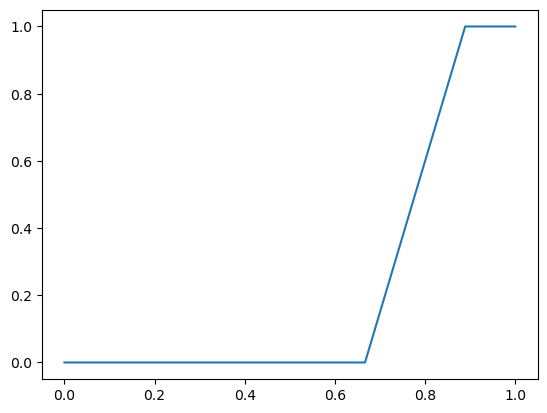

In [101]:
p, r, f, roc_auc, rcurve = eval_model(mort_code_naive_rnn, mort_cemb_val_loader)

plt.plot(rcurve[0], rcurve[1])
plt.show()

### Train: DescEmb

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(naive_rnn.parameters(), lr=0.001)


In [ ]:
# number of epochs to train the model
n_epochs = 5
train(naive_rnn, mort_demb_train_loader, mort_demb_train_loader, n_epochs)

In [ ]:
p, r, f, roc_auc, rcurve = eval_model(naive_rnn, val_loader)

plt.plot(rcurve[0], rcurve[1])
plt.show()

### Load BERT Model

See instructions here: 
- https://pypi.org/project/pytorch-pretrained-bert/#examples
- https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial
- Could also get it from pytorch transformers library: https://pytorch.org/hub/huggingface_pytorch-transformers/
- https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/
- https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html - general text embedding.
- https://machinelearningmastery.com/handle-long-sequences-long-short-term-memory-recurrent-neural-networks/ handling long seq
- Encoder/Decoder training for embedding vocab.

In [ ]:

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# TODO(botelho3)`bert-base-uncased` is big. Load `bert-tiny` instead from the filesystem?
# Model available at https://huggingface.co/prajjwal1/bert-tiny.
# model = BERT_CLASS.from_pretrained(PRE_TRAINED_MODEL_NAME_OR_PATH, cache_dir=None)

# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
if USE_GPU_:
    tokens_tensor = tokens_tensor.to(GPU_STRING_)
    segments_tensors = segments_tensors.to(GPU_STRING_)
    model.to(GPU_STRING_)

# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'

In [ ]:
# Use Dataset Transforms to overwrite the old Dataset with a new transformed dataset.
# Can either construct a new class BertDataset(Dataset): __init__(self, old_dataset)
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
# Or can leverage transfomrs
# class Rescale(object): __init__(self) -> class BertTransform() __init__(bert_model), __call__(self, sample)